#### DTSC6012001 - Model Deployment
Nama: Vira Fitriyani<br>
NIM: 2602068706<br>
MID Exam<br>

#### Library

In [3]:
!pip install xgboost

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

import xgboost
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

#### Setup Data

In [76]:
df = pd.read_csv('data_D.csv')

In [77]:
df.head()

,Unnamed: 0,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
0,0,106473,15639576,Sarratt,652.0,France,Female,65.0,3,0.00,2,1,1,136592.24,0
1,1,62345,15769582,Hanson,464.0,France,Male,35.0,4,0.00,1,0,0,99505.75,1
2,2,126615,15675888,Austin,620.0,Germany,Female,39.0,6,129401.87,2,1,1,102681.32,1
3,3,35909,15786617,Tuan,598.0,France,Female,30.0,7,0.00,2,1,0,141210.18,0
4,4,45175,15757310,Li Fonti,682.0,Germany,Female,46.0,4,107720.57,1,0,0,93832.33,1


In [78]:
df.tail()

,Unnamed: 0,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
41254,41254,105680,15671769,Nkemdirim,567.0,France,Female,37.0,1,121801.49,1,0,0,177028.00,0
41255,41255,70760,15570299,Martin,584.0,Germany,Female,31.0,4,152622.34,1,1,0,99298.80,0
41256,41256,3091,15807593,Tseng,684.0,France,Male,36.0,4,0.00,1,1,0,152992.04,0
41257,41257,20130,15583460,Nwankwo,709.0,France,Male,38.0,3,0.00,2,1,1,185580.23,0
41258,41258,161328,15681655,Hs?,850.0,France,Male,43.0,2,0.00,2,1,1,93882.93,0


In [79]:
df.shape

(41259, 15)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41259 entries, 0 to 41258
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       41259 non-null  int64  
 1   id               41259 non-null  int64  
 2   CustomerId       41259 non-null  int64  
 3   Surname          41259 non-null  object 
 4   CreditScore      41251 non-null  float64
 5   Geography        41259 non-null  object 
 6   Gender           41259 non-null  object 
 7   Age              41259 non-null  float64
 8   Tenure           41259 non-null  int64  
 9   Balance          41259 non-null  float64
 10  NumOfProducts    41259 non-null  int64  
 11  HasCrCard        41259 non-null  int64  
 12  IsActiveMember   41259 non-null  int64  
 13  EstimatedSalary  41259 non-null  float64
 14  churn            41259 non-null  int64  
dtypes: float64(4), int64(8), object(3)
memory usage: 4.7+ MB


#### Split Data

In [118]:
input_df = df.drop('churn', axis=1)
output_df = df['churn']

In [119]:
x_train, x_test, y_train, y_test = train_test_split(input_df, output_df, test_size = 0.2, random_state = 42)

#### Preprocessing Data

In [120]:
# Convert categorical to numerical
gender_encoded= {"Gender": {"Male":1, "Female":0}}
x_train = x_train.replace(gender_encoded)
x_test = x_test.replace(gender_encoded)

In [121]:
df['Geography'].value_counts()

France     23520
Spain       9081
Germany     8658
Name: Geography, dtype: int64

In [123]:
label_encoding = LabelEncoder()
onehot_encoding = OneHotEncoder()

x_train['Surname'] = label_encoding.fit_transform(x_train['Surname'])
x_test['Surname'] = label_encoding.fit_transform(x_test['Surname'])

geo_enc_train = x_train[['Geography']]
geo_enc_test = x_test[['Geography']]

geo_enc_train = pd.DataFrame(onehot_encoding.fit_transform(geo_enc_train).toarray(), columns=onehot_encoding.get_feature_names_out())
geo_enc_test = pd.DataFrame(onehot_encoding.fit_transform(geo_enc_test).toarray(), columns=onehot_encoding.get_feature_names_out())

x_train = x_train.reset_index()
x_test = x_test.reset_index()

x_train_enc=pd.concat([x_train,geo_enc_train], axis=1)
x_test_enc=pd.concat([x_test,geo_enc_test], axis=1)

In [138]:
onehot_encoding.get_feature_names_out()

array(['Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype=object)

In [140]:
x_train_enc.head()

,index,Unnamed: 0,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,23629,23629,15068,15796722,1453,708.0,France,0,45.0,2,0.0,1,1,0,182076.97,1.0,0.0,0.0
1,6996,6996,85710,15591711,1972,676.0,Spain,1,35.0,7,0.0,2,1,0,166053.92,0.0,0.0,1.0
2,26510,26510,55520,15666047,601,645.0,France,0,36.0,4,133980.8,1,1,1,112333.63,1.0,0.0,0.0
3,40020,40020,157017,15716443,397,791.0,Spain,1,37.0,1,0.0,2,1,0,132973.17,0.0,0.0,1.0
4,17668,17668,19223,15778955,1902,637.0,France,0,48.0,7,0.0,2,1,1,146573.66,1.0,0.0,0.0


In [144]:
# Missing Value
x_train_enc.isna().sum()

index                0
Unnamed: 0           0
id                   0
CustomerId           0
Surname              0
CreditScore          7
Geography            0
Gender               0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Geography_France     0
Geography_Germany    0
Geography_Spain      0
dtype: int64

In [145]:
x_test_enc.isna().sum()

index                0
Unnamed: 0           0
id                   0
CustomerId           0
Surname              0
CreditScore          1
Geography            0
Gender               0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Geography_France     0
Geography_Germany    0
Geography_Spain      0
dtype: int64

<AxesSubplot:>

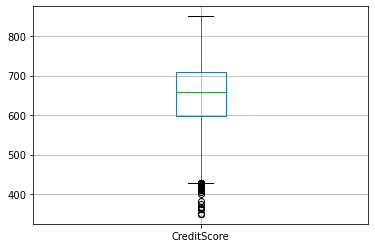

In [146]:
x_train_enc.boxplot(column=['CreditScore'])

In [147]:
# Handling Missing Values with Median, cause there's outliers in CreditScore
print("Median CreditScore: ", x_train_enc['CreditScore'].median())

Median CreditScore:  659.0


In [148]:
x_train_enc['CreditScore'].fillna(659.0, inplace=True)
x_test_enc['CreditScore'].fillna(659.0, inplace=True)

In [149]:
x_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33007 entries, 0 to 33006
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              33007 non-null  int64  
 1   Unnamed: 0         33007 non-null  int64  
 2   id                 33007 non-null  int64  
 3   CustomerId         33007 non-null  int64  
 4   Surname            33007 non-null  int64  
 5   CreditScore        33007 non-null  float64
 6   Geography          33007 non-null  object 
 7   Gender             33007 non-null  int64  
 8   Age                33007 non-null  float64
 9   Tenure             33007 non-null  int64  
 10  Balance            33007 non-null  float64
 11  NumOfProducts      33007 non-null  int64  
 12  HasCrCard          33007 non-null  int64  
 13  IsActiveMember     33007 non-null  int64  
 14  EstimatedSalary    33007 non-null  float64
 15  Geography_France   33007 non-null  float64
 16  Geography_Germany  330

In [131]:
# Deskripsi Statistik
df.describe()

,Unnamed: 0,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
count,41259.000000,41259.000000,4.125900e+04,41251.000000,41259.000000,41259.000000,41259.000000,41259.000000,41259.000000,41259.000000,41259.000000,41259.000000
mean,20629.000000,82171.693231,1.569221e+07,656.278733,38.060254,4.999127,55712.496615,1.554328,0.754405,0.496667,112308.502138,0.211324
std,11910.591715,47498.739183,7.137974e+04,80.062353,8.801094,2.802930,62858.019091,0.545629,0.430445,0.499995,50367.874510,0.408252
min,0.000000,3.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,10314.500000,41098.500000,1.563347e+07,598.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74580.800000,0.000000
50%,20629.000000,81851.000000,1.569013e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117036.380000,0.000000
75%,30943.500000,123064.500000,1.575714e+07,710.000000,42.000000,7.000000,120165.300000,2.000000,1.000000,1.000000,154811.290000,0.000000
max,41258.000000,165033.000000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


Text(0.5, 1.0, 'Variables Correlating with Churn')

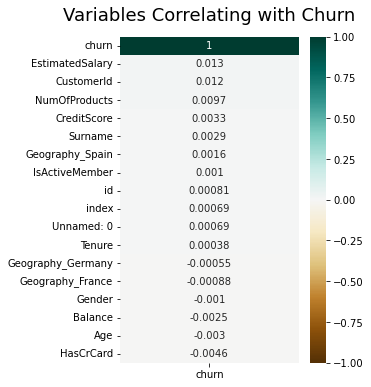

In [150]:
# Correlation Check
train_data = pd.concat([x_train_enc, y_train], axis=1)
plt.figure(figsize=(4,6))
heatmap = sns.heatmap(train_data.corr() [['churn']].sort_values(by='churn', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Variables Correlating with Churn', fontdict={'fontsize':18},pad=16)

Berdasarkan tingkat korelasi dan juga deskripsi dari data, beberapa variabel yang mungkin tidak menggambarkan identitas nasabah dan/atau tidak berkaitan dengan perbankan akan saya drop, yaitu:
- Surname -> berkaitan dengan identitas tetapi tidak mempengaruhi analisis bank
- id -> karena sudah terdapat CustomerId
- Unnamed: 0 -> data hanya berisi index

In [152]:
x_train_enc = x_train_enc.drop(columns=['Surname', 'id', 'Unnamed: 0', 'CustomerId', 'Geography'])
x_train_enc.columns

Index(['index', 'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')

In [153]:
x_test_enc = x_test_enc.drop(columns=['Surname', 'id', 'Unnamed: 0', 'CustomerId', 'Geography'])
x_test_enc.columns

Index(['index', 'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')

KeyError: "None of [Index(['Geography'], dtype='object')] are in the [columns]"

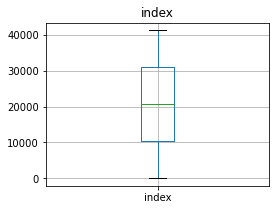

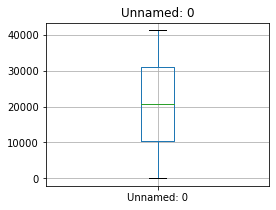

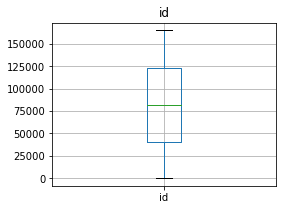

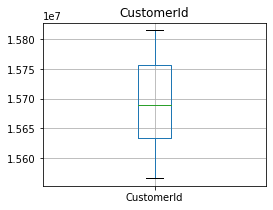

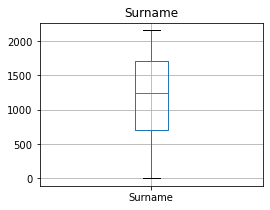

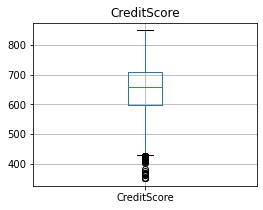

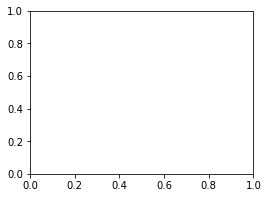

In [154]:
# Outliers Check
#for col in train_data.columns:
#  plt.figure(figsize=(4,3))
 # train_data.boxplot([col])
  #plt.title(col)

#plt.show()

Outliers -> data yang menyimpang secara signifikan dari data normal. Outlier perlu untuk diidentifikasi dan ditangani karena  memungkinkan berdampak terhadap hasil analisis statistik.<br>

Dari visualisasi boxplot diatas, dapat dilihat beberapa variabel yang memiliki data outlier, yaitu:
* CreditScore
* Age
* NumOfProducts
* HasCrCard
* churn

In [136]:
# Count jumlah outliers tiap variabel
#def count_outliers(column):
 #   Q1 = column.quantile(0.25)
  #  Q3 = column.quantile(0.75)
   # IQR = Q3 - Q1
    #lower_bound = Q1 - 1.5 * IQR
    #upper_bound = Q3 + 1.5 * IQR
    #outliers = column[(column < lower_bound) | (column > upper_bound)]
    #return len(outliers)

#train_data.apply(count_outliers)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
# Cek jumlah target variabel tiap klasifikasi karena terdapat outlier di kelas 1
train_data['churn'].value_counts()

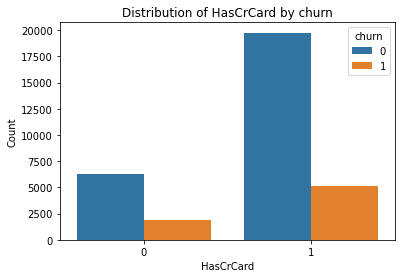

In [100]:
sns.countplot(x='HasCrCard', hue='churn', data=train_data)
plt.xlabel('HasCrCard')
plt.ylabel('Count')
plt.title('Distribution of HasCrCard by churn')
plt.show()

Keputusan outlier tidak di handling, dengan beberapa faktor alasan berikut:
- Variabel "Churn" memiliki imbalanced data yang sangat jauh sekitar 26.8%. Sehingga tidak memungkinkan untuk di oversampling atau undersampling.
- Variabel "HasCrCard" juga memiliki imbalanced data yang tinggi, namun berdasarkan distribusinya terhadap churn terdistribusi normal. Dimana lebih banyak customer yang memiliki HasCrCard tidak churn.
- Variabel "Age", "CreditScore" dan "NumOfProducts" memiliki jumlah outlier yang relatif kecil dibandingkan dengan jumlah data yang ada. Sehingga mungkin tidak berpengaruh besar terhadap hasil analisis.

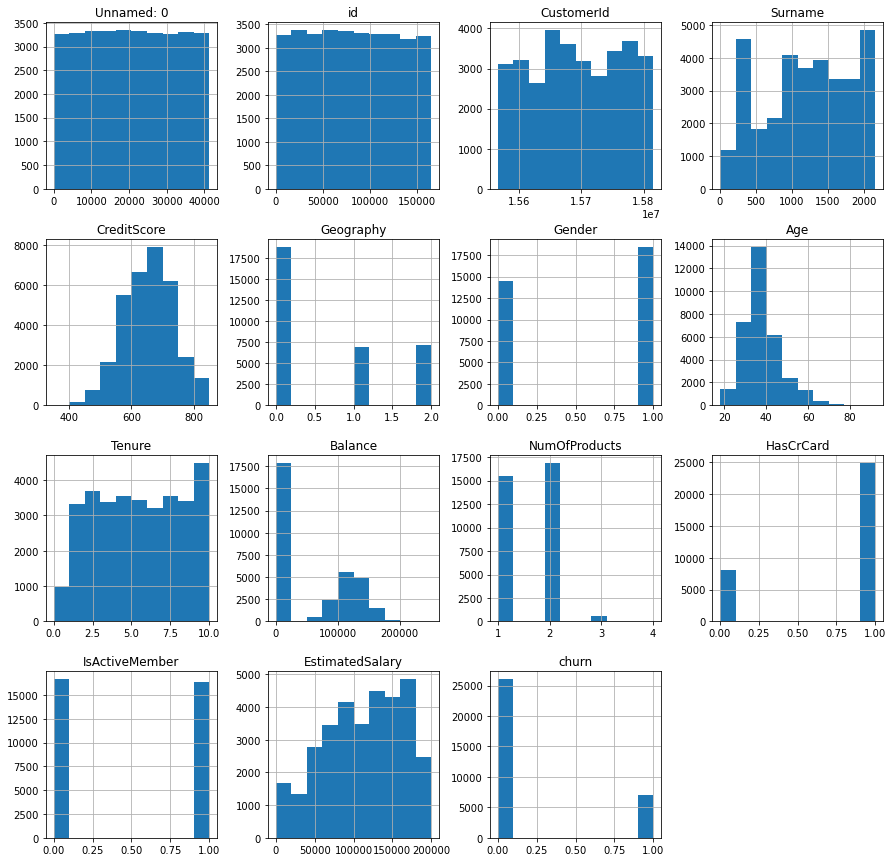

In [101]:
# Distribution Check
plot = train_data.hist(figsize=(15,15))

**Scaling Data** -> untuk memastikan bahwa seluruh fitur dalam dataset memiliki skala yang sama.
<br><br>
Pendekatan scaling yang akan saya gunakan adalah '**RobustScaler**'. Karena 'RobustScaler' merupakan salah satu metode scaling yang robust terhadap outlier. Metode yang digunakan untuk mengubah fitur berdasarkan median dan IQR, sehingga lebih stabil.

In [155]:
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train_enc)
x_test_scaled = scaler.fit_transform(x_test_enc)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train_enc.columns)

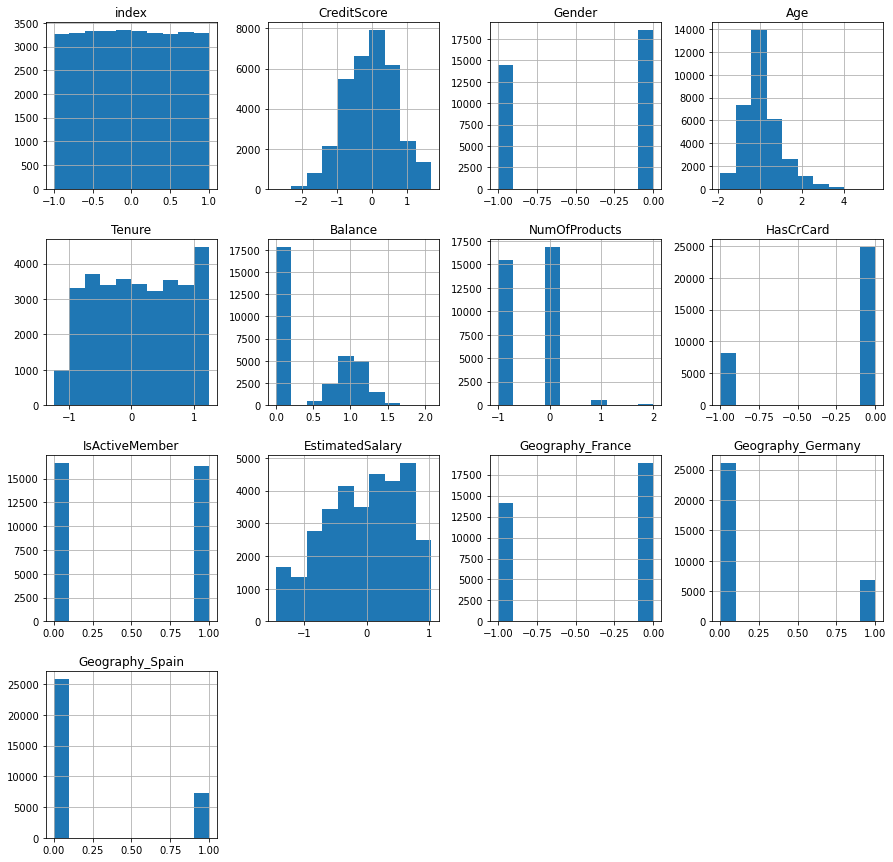

In [156]:
plot = x_train_scaled.hist(figsize=(15,15))

#### Random Forest

In [157]:
# Tunning Parameter using GridSearchCV
parameters = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth':[2,4,6,8],
    'n_estimators':[50, 100, 150]
}

In [158]:
RF_model = RandomForestClassifier()
RF_model = GridSearchCV(RF_model, param_grid=parameters, scoring='accuracy', cv=5)

RF_model.fit(x_train_scaled, y_train)
print("Tuned Hyperparameters :", RF_model.best_params_)
print("Accuracy :",RF_model.best_score_)

Tuned Hyperparameters : {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 150}
Accuracy : 0.8594539782443252


In [159]:
best_RF_model = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=150)
best_RF_model.fit(x_train_scaled, y_train)

RandomForestClassifier(max_depth=8, n_estimators=150)

In [160]:
y_predict = best_RF_model.predict(x_test_scaled)

In [161]:
print('\nClassification Report\n')
print(classification_report(y_test, y_predict, target_names=['0','1']))


Classification Report

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      6513
           1       0.67      0.53      0.60      1739

    accuracy                           0.85      8252
   macro avg       0.78      0.73      0.75      8252
weighted avg       0.84      0.85      0.84      8252



#### XGBoost

In [162]:
parameters_xgb = {
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2]
}

In [163]:
XGB_model = XGBClassifier()

In [164]:
XGB_model = GridSearchCV(XGB_model, param_grid=parameters_xgb, scoring='accuracy', cv=5)
XGB_model.fit(x_train_scaled, y_train)
print("Tuned Hyperparameters :", XGB_model.best_params_)
print("Accuracy :",XGB_model.best_score_)

Tuned Hyperparameters : {'gamma': 0, 'max_depth': 2, 'n_estimators': 100}
Accuracy : 0.8636046120631755


In [165]:
XGB_model = XGBClassifier(gamma=0, max_depth=2, n_estimators=100)
XGB_model.fit(x_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [166]:
y_predict1 = XGB_model.predict(x_test_scaled)

In [167]:
print('\nClassification Report\n')
print(classification_report(y_test, y_predict1, target_names=['0','1']))


Classification Report

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      6513
           1       0.65      0.59      0.62      1739

    accuracy                           0.85      8252
   macro avg       0.77      0.75      0.76      8252
weighted avg       0.84      0.85      0.85      8252



In [168]:
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

print("RF Model")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

precision1 = precision_score(y_test, y_predict1)
recall1 = recall_score(y_test, y_predict1)
f11 = f1_score(y_test, y_predict1)

print("\nXGB Model")
print("Precision:", precision1)
print("Recall:", recall1)
print("F1-score:", f11)

RF Model
Precision: 0.6705118961788031
Recall: 0.5347901092581944
F1-score: 0.5950095969289827

XGB Model
Precision: 0.6539923954372624
Recall: 0.5934445083381253
F1-score: 0.622249020198975


#### Kesimpulan:

Berdasarkan perbandingan Precision, model Random Forest lebih tinggi dibandingkan XGBoost. Namun, jika dilihat pada nilai Recall dan F1-Scorenya Random Forest lebih rendah dibandingkan XGBoost. Hal ini menunjukkan bahwa kemungkinan XGBoost memiliki performa yang lebih baik dalam memprediksi kelas positif secara keseluruhan.

#### Save best model to Pickle

In [169]:
import pickle

filename = 'XGB_model.pkl'
pickle.dump(XGB_model, open(filename, 'wb'))

filename = 'gender_encode.pkl'
pickle.dump(x_train_scaled, open(filename, 'wb'))

filename = 'geography_oneHot.pkl'
pickle.dump(x_train_scaled, open(filename, 'wb'))